<a href="https://colab.research.google.com/github/jsebastianquiroga/analitica_ia_puj/blob/main/DL/03_convnets_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Convolucionales & Transfer Learning

En este Notebook se llevará acabo el entrenamiento de un modelo de Red Neuronal utilizando Redes Convolcuionales. El objetivo principal es familiarizarse con las redes neuronales convolucionales.


# CIFAR-10 Dataset

El conjunto de datos CIFAR-10 es un conjunto de datos popular utilizado para entrenar y evaluar algoritmos de aprendizaje automático para la clasificación de imágenes. Consiste en 60,000 imágenes a color de 32x32 píxeles, divididas en 10 clases: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión. Hay 6,000 imágenes por clase, con 50,000 imágenes para entrenamiento y 10,000 imágenes para pruebas.


En este ejercicio entrenaremos el mismo modelo de red neuronal en dos escenarios:

1. Escenario con muchos datos
2. Escenario con pocos datos

Lo anterior nos permitirá entender la importancia de los modelos pre-entrenados (¡que veremos la siguiente sesión!)


# Descarga de Información

Los datos de CIFAR-10 se encuentran en [`TensorFlow Datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data) y se puede acceder a ellos utilizando el método `load_data()`. 

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 18.2 MB/s eta 0:00:00


In [ ]:
# Part 1: Building a Convolutional Neural Network from scratch using TensorFlow

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import datasets, models
import matplotlib.pyplot as plt
import numpy as np
import visualkeras


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


Una vez cargada la información, procedemos a visualizar el conjunto de datos. 

In [ ]:
def plot_cifar10_classes():
    # Load the CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    # Combine training images and labels for shuffling
    data = list(zip(train_images, train_labels))

    # Shuffle the data
    np.random.shuffle(data)

    # Initialize an empty array to store an image from each class
    class_images = np.zeros((10, 32, 32, 3), dtype=np.uint8)

    # Iterate over the shuffled data
    for image, label in data:
        if np.sum(class_images) == 10 * 32 * 32 * 3:
            break

        if np.sum(class_images[label]) == 0:
            class_images[label] = image

    # Plot an image from each class
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('CIFAR-10 Classes')

    for i in range(10):
        row = i // 5
        col = i % 5
        ax = axs[row, col]
        ax.imshow(class_images[i])
        ax.set_title(class_names[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the CIFAR-10 classes


In [ ]:
plot_cifar10_classes()


Se puede apreciar que en efecto existen 10 categorías y que las imágenes son de tamaño reducido. 

Antes de entrenar nuestro modelo de Red Neuronal, debemos normalizar nuestros datos. Como se trata de imágenes RGB, cada canal tendrá un valor máximo de 255 (intensidad máxima de R, G o B). 

In [ ]:
### Normalice las imágenes de entrenamiento y prueba dividiendo por 255
train_images, test_images = None, None
###

In [ ]:
# Realizamos división en valdiación también
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
## Acá no hay que modificar nada
def plot_prediction_results(model, num_pixels = None, pre_process_fn = None, resize = None):
    # Load the CIFAR-10 dataset
    (_, _), (test_images, test_labels) = datasets.cifar10.load_data()

    # Get shuffled indices for unique image selection
    num_plots = 10
    indices = np.arange(len(test_images))
    np.random.shuffle(indices)

    sampled_images = test_images[indices[:num_plots]]
    sampled_labels = test_labels[indices[:num_plots]]

    # If you want to apply transformations, make a copy of the sampled images
    # This copy will be used for model predictions
    transformed_images = sampled_images.copy()

    if num_pixels:
        original_shape = test_images.shape
        transformed_images = transformed_images.reshape((num_plots,) + (num_pixels,))
    
    if resize:
        transformed_images = tf.image.resize(transformed_images, resize)

    # Normalize the test images
    if pre_process_fn:
        print('Using Pre-Trained Model Process')
        pred_images = pre_process_fn(transformed_images)
    else:
        pred_images = transformed_images.astype('float32') / 255

    # Get predictions from the model on the random sample
    predictions = model.predict(pred_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    # Plot random image, predicted label, true label, and prediction probability
    fig, axs = plt.subplots(2, 5, figsize=(12, 8))
    fig.suptitle('Prediction Results')

    for i in range(num_plots):
        row = i // 5
        col = i % 5
        ax = axs[row, col]

        # Select a unique test sample
        image = sampled_images[i]
        true_label = sampled_labels[i][0]
        predicted_label = predicted_labels[i]
        prediction_probability = predictions[i][predicted_label]

        # Set title color based on prediction correctness
        title_color = 'green' if predicted_label == true_label else 'red'

        # Plot the image, labels, and probability
        ax.imshow(image)
        ax.set_title(f'Predicted: {class_names[predicted_label]}\nTrue: {class_names[true_label]}\nProbability: {prediction_probability:.4f}', color=title_color)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Benchmark -- Simple Neural Network

Para evaluar la efectividad (o superioridad) de las Redes Neuronales Convolucionales, entrenaremos una red neuronal densa simple que ignora la dependencia espacial de los datos.

¿Recordamos el Flattenq ue hacíamos al comienzo? Bueno, en esta sección se debe aplicar una estrategia de reshaping, bues se tienen tres canales. R, G, y B. Cada canal tiene dimensión 32*32.

![Ejemplo Canales](https://i.stack.imgur.com/I4p5q.png)

En este caso, se debería hacer el flatten de cada imagen y concatenar verticalmente los vectores. 

Vamos paso a paso.


1. Determinar el tamaño del vector de cada canal
2. Sumar y determinar el tamaño del vector final
3. Hacer reshape de la imagen original en el tamaño del vector (ponerlo en una hillera)

El primer paso es sencillo, pues todos los canales tienen el mismo tamaño de imagen. Basta con encontrar uno para tener el tamaño de todos los vectores.

In [ ]:
### Determina el Tamaño del vector para el canal rojo
### Pista: se calcula ancho por alto
ancho, alto = None, None
vector_canal = None
###

Una vez  se tiene `vector_canal` se conoce el número de pixeles que hay en total en cada canal. Por lo que el número de pixeles disponible sen la imagen es `vector_canal` multiplicado por el número de canales (en este caso, 3). 

In [ ]:
### Encuentra el número total de pixeles informativos de la imagen
num_pixels = None
###

Basado en lo anterior, ya es posible realizar un reshape de las imágenes de entrenamiento y prueba, para que puedan ser utilizadas por la red neuronal simple. Utiliza el método [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) para modificar el la dimensión de la imagen a un vector de tamaño `num_pixels`. 

In [ ]:
### Reshape de imágenes de tran y test (asignar nuevo nombre...)

train_images_flatten =  None
val_images_flatten =  None
test_images_flatten =  None

###

¡Y ahora sí comienza lo bueno! 

Utilizando lo aprendido hasta el momento, crea un modelo de red neuronal densa (sencillo) para predecir la categoría de cada imagen. 

In [ ]:
### Defina la arquitectura del modelo

simple_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(num_pixels, )), # Dejarla
  None

])
###

In [ ]:
### Complie el modleo
None
###

Una vez definido y compilado el modelo, se puede realizar una visualización de la cantidad de parámetros que se van a entrenar. Utilice el método [`.summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) para inspeccionar la arquitectura planteada.

In [ ]:
simple_model.summary()

Adicionalmente, utilizando la librería `visualkeras` puede entender gráficamente cómo es la red neuronal que planteó. 

In [ ]:
visualkeras.layered_view(simple_model).show()

Una vez inspeccionado el modelo, entrénelo por 10 epochs (a modo de ejemplo. Pero puede utilizar muchas más si lo desea). No olvide incluir callbacks de EarlyStopping. No olvide incluir el dataset de valdiación.

In [ ]:
### Entrene su modelo
early_stopping = None

history_simple = None
###

In [ ]:
### Utilice el método `.evaluate` para determinar el desempeño del modelo en test 

test_loss, test_acc = None
print('\nTest accuracy:', test_acc)

###

¿Cómo le dio al modelo? ¿Es un buen modelo?

In [ ]:
plot_prediction_results(simple_model, num_pixels)

## Red Convolucional

Una vez entrenado un modelo que ingora la información espacial que se encuentra en las imágenes, se realizará el entrenamiento de un modelo con redes neuronales convolucionales. 

Para esto recuerde que la arquitectura típica de una CNN es como sigue ![Arquitectura típica CNN](https://d33wubrfki0l68.cloudfront.net/a7664cf19de33b2c71a482629f27a0d70f715b77/6949d/images/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way.jpg).

Utilice elemenso como:
- Convoluciones: [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), se sugiere kernel size `(3, 3)`. 
- Pooling Layers: [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) o [`AveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) para el downsampling, se sugiere pool_size size `(2, 2)`.
- [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
- [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [ ]:
### Defina su modelo de Red Neuronal
model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(ancho, alto, 3)), # Dejarlo
    None
])

###


In [ ]:
### Compile su modelo
None

###

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
visualkeras.layered_view(model).show()

¡Y realice el entrenamiento del modelo! Nuevamente, se sugiere con 10 epochs para la clase, pero en su tiempo libre puede entrenarlo con más. 

In [ ]:
### Entrene su modelo
history_model = None

###

A continuación, revise el desempeño de su modelo en Test. ¿Qué tal el accuracy? ¿Está satisfecho?

In [ ]:
plot_prediction_results(model)

In [ ]:
model.evaluate(test_images, test_labels)

---
# Transfer Learning

En esta sección veremos cómo hacer Transfer Learning y Fine-Tuning de un modelo pre-entrenado con ImageNet para la generar un modelo que sí sea capaz de predecir adecuadamente estas clases.

En la clase anterior vimos que existían algunos modelos famosos que habían ganado la competencia de ImageNet, como lo eran VGG16, ResNet50, GoogLeNet, entre otros. 

Estos modelos tienen la capacidad de reconocer muchísimas clases (22k) de objetos `naturales`. Por medio del fine-tuning, explotaremos los feature extractors de estos modelos, para llevarlo a un dominio nuevo (nuestras 10 clases). 

En esta demostración se utilizará como candidado [`ResNet50`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50), pero se recomienda que pruebe los otros modelos disponibles:

- [`VGG16`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)
- [`InceptionV3`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3)

## Importe del Modelo

A continuación, cargue el modelo que haya escogido utilizando lo smétodos descritos en la documentación. 

Este modelo se va a llamar `base_model` y corresponde al extractor de características. 

Los parámetros que debe tener en cuenta son:
- `include_top = False`: pues no se busca predecir las mismas clases que el modelo sabe predecir
- `weights = 'imagenet'`: Se indica que se desea cargar los pesos del modelo que predice las clases de ImageNet.


Si va a utilizar un modelo diferente ResNet50, por favor cargue la función de pre-procesamiento requerida en `pre_process_fn`. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
### Cargue el Modelo
base_model = ResNet50(weights='imagenet', include_top=False)
###


pre_process_fn = tf.keras.applications.resnet50.preprocess_input

94765736/94765736 [==============================] - 0s 0us/step


Normalmente, se utilizan modelos muy grandes que ya fueron entrenados en un conjunto enorme de información. A continuación, se puede observar el tamaño del modelo base que se ecogió.

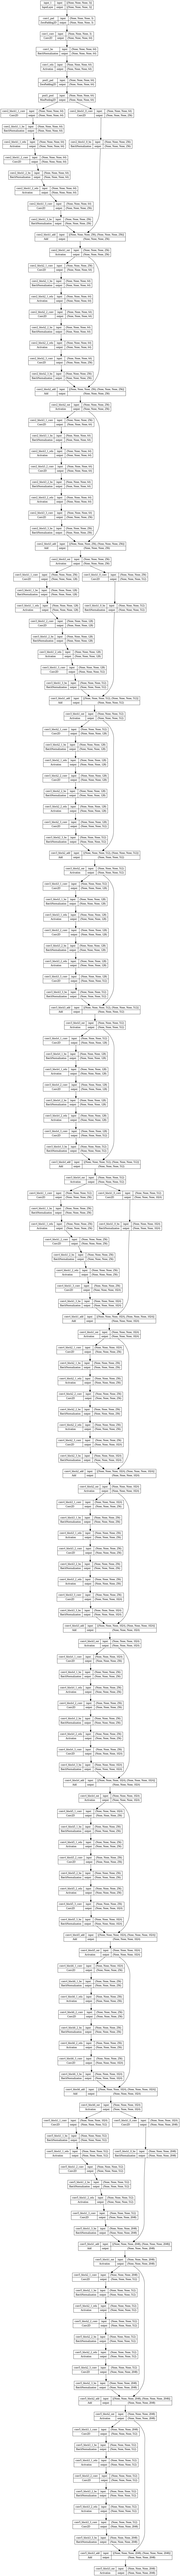

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Una vez realizado este procedimiento, `base_model` es un extractor de características, que se desea pasar por un nuevo modelo para predecir las 10 clases de nuestro problema. 

A continuación, defina el nuevo modelo: añada capas ocultas y una capa de salida:

- Después de la extracción de características aplique una capa con [`GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)

In [ ]:
x = base_model.output # Corresponde a los features que extrae el modelo

### Continúe la construcción del Modelo 

x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D
x = Dense(2023, activation='relu')(x) # Añada las capas ocultas que desee
predictions = tf.keras.layers.Dense(10, activation='softmax')(x) # Añada la capa de salida (predicción de las clases)

###


A continuación, se crea el `fine_tune_model` que contiene el modelo inicial, más las capas adicionales de salida que se añadieron en la celda anterior. 

In [ ]:
fine_tune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

Adicionalmente, es importante indicar que **no se quiere dañar lo que el modelo ya sabe**, sino únicamente crear un modelo capaz de tomar ese feature extractor y crear un modelo sobre ese. Por esto, se **congelan** las capas del modelo base. 

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Finalmente, se realiza la compilación y entrenamiento (inicial) del modelo. Utilice [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) como optimizador con parámetro `learning_rate = 0.001`.

In [ ]:
### Compile el Modelo
fine_tune_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.001))
###

In [ ]:
fine_tune_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

Para realizar el entrenamiento de este modelo, es necesario transformar los datos de forma que tengan las dimensiones esperadas (input_shape) y contengan los valores en el rango deseado por el modelo. 

Por ejemplo, ResNet50 utiliza imágenes de `224x224x3` y normaliza los valores entre `-1 y 1`. Los procesaimentos específicos se encuentran en `pre_process_fn`. 

El siguiente bloque de código transforma la información para que sea la esperada por el modelo. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
## No modificar nada (salvo new_size si cambió el modelo)

# Carga nuevamente de información
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
# Expected Size
new_size = (224, 224)

# Convierte en TF Datasets (completo no cabe en memoria)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))



# Transformación de Imágenes: Resize + Normalization
def preprocess(image, label):
    image = tf.image.resize(image, new_size)
    image = pre_process_fn(image) 
    return image, label

# Apply the function to the datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Shuffle and batch the datasets
BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_fine_tune_model = fine_tune_model.fit(train_dataset, epochs=5,
                    validation_data=(val_dataset),  callbacks=[early_stopping])


Epoch 1/5
2500/2500 [==============================] - 175s 69ms/step - loss: 0.1592 - sparse_categorical_accuracy: 0.9446 - val_loss: 0.3289 - val_sparse_categorical_accuracy: 0.9007
Epoch 2/5
2500/2500 [==============================] - 182s 72ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.3365 - val_sparse_categorical_accuracy: 0.9044
Epoch 3/5
2500/2500 [==============================] - 180s 71ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.3551 - val_sparse_categorical_accuracy: 0.9091
Epoch 4/5
2500/2500 [==============================] - 172s 67ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.4008 - val_sparse_categorical_accuracy: 0.9052


In [ ]:
fine_tune_model.evaluate(test_dataset)

625/625 [==============================] - 34s 54ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.9004


[0.34487244486808777, 0.9003999829292297]

Using Pre-Trained Model Process
1/1 [==============================] - 2s 2s/step


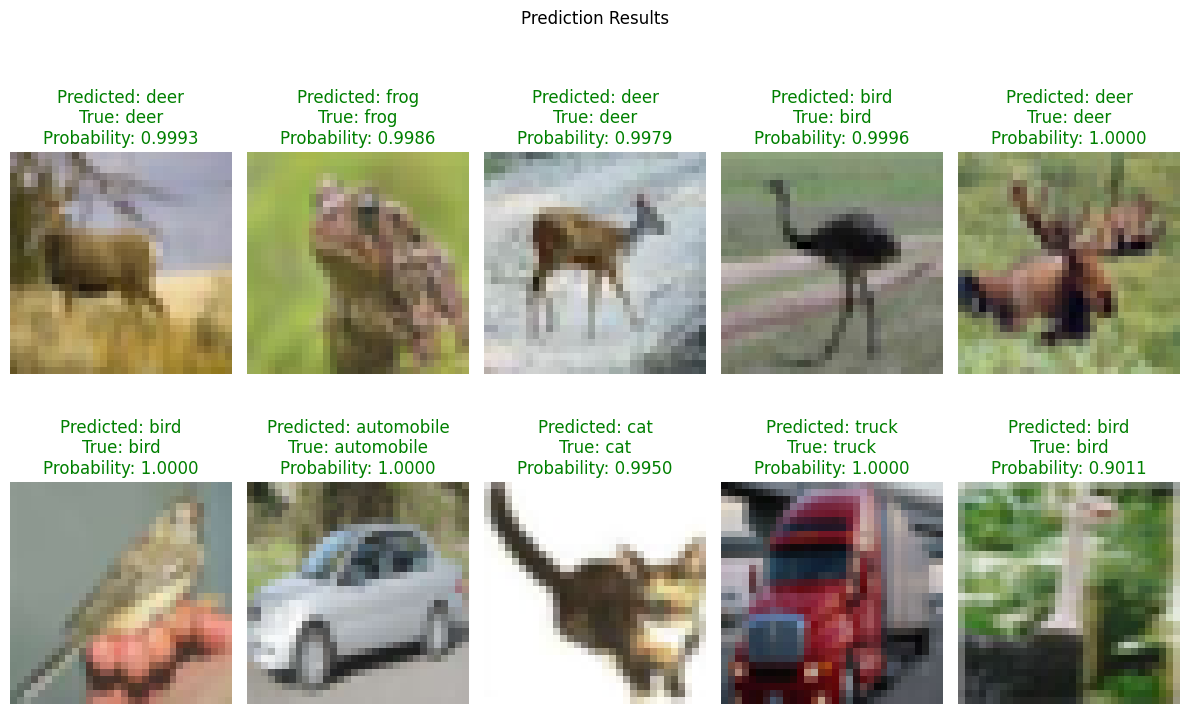

In [ ]:
plot_prediction_results(fine_tune_model, pre_process_fn = pre_process_fn, resize = new_size)

# Fine-Tuning Even Further!

En este punto, vimos claramente cómo el modelo con apenas un epoch, logra un accuracy cercano a 90% en validación y en test (vale la pena revisar las demás métricas). ¿Podemos hacer que el modelo de mucho mejor?

¡Pues sí! 

Lo que haremos a continuación es permitir entrenar un poco más las capas finales. En la sección anterior entrenamos las capas densas que pusimos y no tocamos el extractor de características. ¿Por qué no mejoramos un poco la manera en que extraemos información?

En el entrenamiento, disminuya la tasa de aprendizaje a `learning_rate = 0.0001`.

In [ ]:
for layer in base_model.layers[143:]:
    layer.trainable = True


### Compile el Modelo
fine_tune_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001))
###

history_fine_tune_model = fine_tune_model.fit(train_dataset, epochs=5,
                    validation_data=(val_dataset),   callbacks=[early_stopping])



Epoch 1/5
2500/2500 [==============================] - 252s 95ms/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.2337 - val_sparse_categorical_accuracy: 0.9265
Epoch 2/5
2500/2500 [==============================] - 240s 95ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.2484 - val_sparse_categorical_accuracy: 0.9281
Epoch 3/5
2500/2500 [==============================] - 231s 92ms/step - loss: 0.0656 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.2600 - val_sparse_categorical_accuracy: 0.9294
Epoch 4/5
2500/2500 [==============================] - 240s 95ms/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.2459 - val_sparse_categorical_accuracy: 0.9343


In [ ]:
fine_tune_model.evaluate(test_dataset)

625/625 [==============================] - 34s 55ms/step - loss: 0.2415 - sparse_categorical_accuracy: 0.9230


[0.24154537916183472, 0.9229999780654907]

# Embedding Visualization

En esta sección vemos que el modelo no sólo fue capaz de clasificar adecuadamente todas las categorías. Sino que también aprendió a extraer características específicas de los grupos de CIFAR 10. 

In [ ]:
import pandas as pd

In [ ]:
# No modificar nada
def visualize_embeddings(model, pre_process_fn = None, num_pixels = None, resize = None):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    import seaborn as sns

    # Load the CIFAR-10 dataset
    (_, _), (test_images, test_labels) = datasets.cifar10.load_data()

    if num_pixels:
        original_shape = test_images.shape
        test_images = test_images.reshape((test_images.shape[0], num_pixels))

    if resize:
        test_images = tf.image.resize(test_images, resize)

    # Normalize the test images
    if pre_process_fn:
        print('Using Pre-Trained Model Process')
        test_images = pre_process_fn(test_images)
    else:
        test_images = test_images.astype('float32') / 255

    # Extract embeddings from the base model
    embeddings = model.predict(test_images)

    # Flatten the embeddings
    embeddings = embeddings.reshape(embeddings.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=60)
    embeddings_pca = pca.fit_transform(embeddings)

    # Apply t-SNE
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings_pca)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame(embeddings_tsne, columns=['comp1', 'comp2'])
    df['labels'] = test_labels.flatten()

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
    df['labels'] = df['labels'].map(class_names)

    # Plot t-SNE visualization with seaborn
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, x='comp1', y='comp2', hue='labels', palette='tab10', alpha=0.7)
    plt.title('t-SNE Visualization of Image Embeddings')
    plt.show()


In [ ]:
feature_extractor = tf.keras.Model(inputs=fine_tune_model.input, outputs=fine_tune_model.get_layer('global_average_pooling2d').output)


Using Pre-Trained Model Process
313/313 [==============================] - 4s 8ms/step


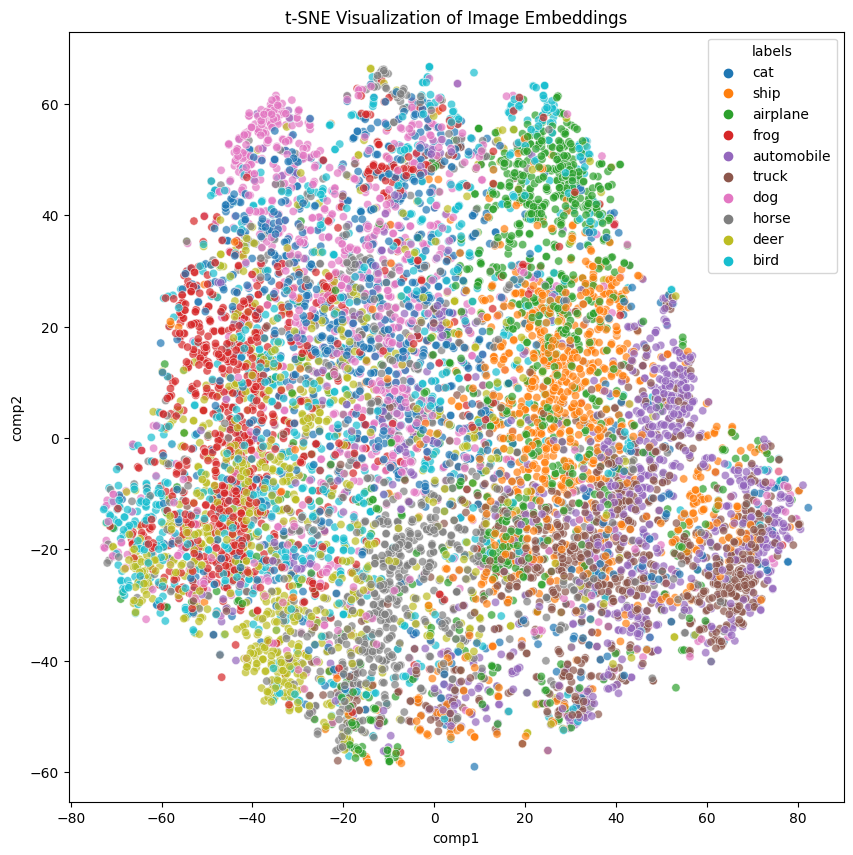

In [ ]:
visualize_embeddings(feature_extractor, pre_process_fn=pre_process_fn)